In [69]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

In [70]:
def oneHotEncode(df):
    onehot_encoder = OneHotEncoder(sparse=False)

    column = df['sentiment'].values.reshape(-1, 1)
    column_encoded = onehot_encoder.fit_transform(column)
    encoded_df = pd.DataFrame(column_encoded, columns=onehot_encoder.get_feature_names(['sentiment']))

    df = pd.concat([df, encoded_df], axis=1)

    return df.drop('sentiment', axis=1)


def getAccuracy(df):
    """
    A predicted BUY (SELL) should be classified as correct if the stock 
    price increases (decreases), even if the labelled action is HOLD
    """
    correct = 0
    
    for index, row in df.iterrows():
        if row['prediction'] == row['action']:
            correct += 1
        elif row['prediction'] == 'BUY' and row['price_change_percent'] > 0:
            correct += 1
        elif row['prediction'] == 'SELL' and row['price_change_percent'] < 0:
            correct += 1
            
    accuracy = correct / len(df)

    return accuracy

In [104]:
data = pd.read_csv('new2_current_progress_labelled.csv')
data = oneHotEncode(data)

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

X_train = train_data[['sentiment_negative', 'sentiment_neutral', 'sentiment_positive']]
y_train = train_data[['action']]
X_test = test_data[['sentiment_negative', 'sentiment_neutral', 'sentiment_positive']]
y_test = test_data[['action']]

### Multi-Class Logistic Regression

In [105]:
clf = LogisticRegression(random_state=42, multi_class='multinomial', solver='lbfgs')

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

test_data['prediction'] = y_pred

getAccuracy(test_data)

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/tmp/ipykernel_3404395/4060252764.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction'] = y_pred


0.41975308641975306

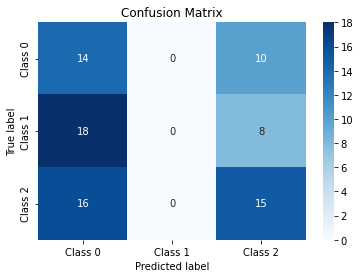

In [106]:
cm = confusion_matrix(test_data['action'], test_data['prediction'])

cm_df = pd.DataFrame(cm, columns=['Class 0', 'Class 1', 'Class 2'], index=['Class 0', 'Class 1', 'Class 2'])

# create heatmap using seaborn library
sns.heatmap(cm_df, annot=True, cmap='Blues')

plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### XGBoost

In [22]:
import xgboost as xgb

le = LabelEncoder()
y_train_numeric = pd.DataFrame()
y_train_numeric['action'] = le.fit_transform(train_data['action'])

model = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=10,
    max_depth=4,
    objective='multi:softmax',
    num_classes=3,
    eval_metric='mlogloss'
)

model.fit(X_train, y_train_numeric)

y_pred = model.predict(X_test)

test_data['prediction'] = le.inverse_transform(y_pred)

getAccuracy(test_data)

[22:56:59] WARNING: ../src/learner.cc:767: 
Parameters: { "num_classes" } are not used.



/tmp/ipykernel_3404395/881266142.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction'] = le.inverse_transform(y_pred)


0.48247978436657685

### KNN

In [26]:
from sklearn.neighbors import KNeighborsClassifier

le = LabelEncoder()
y_train_numeric = pd.DataFrame()
y_train_numeric['action'] = le.fit_transform(train_data['action'])

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

test_data['prediction'] = y_pred

getAccuracy(test_data)

/opt/conda/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/conda/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/tmp/ipykernel_3404395/3626877439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

0.48247978436657685

In [39]:
data['action'].value_counts()

BUY     664
SELL    600
HOLD    591
Name: action, dtype: int64